# Word2Vec

Let's work on skipgram-based implementation of word2vec.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Detect the device for computation (CPU/GPU/Metal on Mac 💻)
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: cuda


## 1. Define some very simple data for understanding


In [3]:
import nltk
from nltk.corpus import reuters

# SAMPLE_SIZE = 100
SAMPLE_SIZE = len(reuters.fileids())
corpus = []


for id in reuters.fileids()[:SAMPLE_SIZE]:
    sentences = reuters.words(id)
    sentences = [
        sentence.lower() for sentence in sentences if sentence.isalpha()
    ]
    corpus.append(sentences)

print(corpus[:1])

[['asian', 'exporters', 'fear', 'damage', 'from', 'u', 's', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'u', 's', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asia', 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian', 'capitals', 'a', 'u', 's', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'u', 's', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short', 'term', 'tokyo', 's', 'loss', 'might', 'be', 'their', 'gain', 'the', 'u', 's', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', '

In [4]:
# corpus = [
#     "apple banana fruit",
#     "banana apple fruit",
#     "banana fruit apple",
#     "dog cat animal",
#     "cat animal dog",
#     "cat dog animal",
# ]

In [5]:
# corpus = [sent.split(" ") for sent in corpus]
# corpus

In [6]:
# get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
# vocab

In [7]:
# numericalization
word2index = {w: i for i, w in enumerate(vocab)}
# print(word2index)

In [8]:
# vocab size
voc_size = len(vocab)
# print(voc_size)

In [9]:
# append UNK
vocab.append("<UNK>")

In [10]:
# vocab

In [11]:
word2index["<UNK>"] = 0

In [12]:
# just in case we need to use
index2word = {v: k for k, v in word2index.items()}

## 2. Prepare train data


In [13]:
# for c in corpus:
#     print(c)

In [14]:
def random_batch(batch_size, word_sequence):
    # Make skip gram of one size window
    skip_grams = []
    # Loop through each sentence in the corpus
    for sent in corpus:
        # Loop through each word in the sentence, starting from the second word and stopping at the second last word
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]  # Get the index of the target word
            context = [
                word2index[sent[i - 1]],
                word2index[sent[i + 1]],
            ]  # Get the indices of the context words
            for w in context:
                skip_grams.append(
                    [target, w]
                )  # Append the target-context pair to skip_grams

    random_inputs = []
    random_labels = []
    # Randomly pick indices without replacement
    random_index = np.random.choice(
        range(len(skip_grams)), batch_size, replace=False
    )

    for i in random_index:
        random_inputs.append(
            [skip_grams[i][0]]
        )  # Append the target word index to random_inputs
        random_labels.append(
            [skip_grams[i][1]]
        )  # Append the context word index to random_labels

    return np.array(random_inputs), np.array(
        random_labels
    )  # Return the inputs and labels as numpy arrays

### Testing the method


In [15]:
# Testing the method
batch_size = 2  # mini-batch size

# Generate a random batch of input and target pairs
input_batch, target_batch = random_batch(batch_size, corpus)

# Print the input batch
print("Input: ", input_batch)

# Print the target batch
print("Target: ", target_batch)

# We will convert them to tensor during training, so don't worry...

Input:  [[ 1352]
 [24287]]
Target:  [[10866]
 [   93]]


In [16]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w\_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word


In [17]:
class Skipgram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(Skipgram, self).__init__()
        # Initialize the embeddings for center and target words
        self.embedding_v = nn.Embedding(vocab_size, emb_size).to(device)
        self.embedding_u = nn.Embedding(vocab_size, emb_size).to(device)

    def forward(self, center_words, target_words, all_vocabs):
        # Move tensors to the device
        center_words = center_words.to(device)
        target_words = target_words.to(device)
        all_vocabs = all_vocabs.to(device)

        # Get the embeddings for center and target words
        center_embeds = self.embedding_v(
            center_words
        )  # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(
            target_words
        )  # [batch_size, 1, emb_size]
        all_embeds = self.embedding_u(
            all_vocabs
        )  # [batch_size, voc_size, emb_size]

        # Calculate scores by performing batch matrix multiplication
        scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        # [batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        # Calculate normalized scores
        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        # [batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        # Calculate negative log likelihood loss
        nll = -torch.mean(
            torch.log(
                torch.exp(scores)
                / torch.sum(torch.exp(norm_scores), 1).unsqueeze(1)
            )
        )  # log-softmax
        # scalar (loss must be scalar)

        return nll  # negative log likelihood

## 4. Training


In [18]:
batch_size = 256  # mini-batch size
embedding_size = 100  # so we can later plot
model = Skipgram(voc_size, embedding_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def prepare_sequence(seq, word2index):
    idxs = list(
        map(
            lambda w: (
                word2index[w]
                if word2index.get(w) is not None
                else word2index["<UNK>"]
            ),
            seq,
        )
    )
    return torch.LongTensor(idxs).to(device)


# Use for the normalized term in the probability calculation
# Prepare a tensor of all vocabulary indices, expanded to match the batch size
all_vocabs = (
    prepare_sequence(list(vocab), word2index)
    .expand(batch_size, len(vocab))
    .to(device)
)  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([256, 29174])

In [20]:
def epoch_time(start_time, end_time):
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
import time

# Training
num_epochs = 10
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch).to(device)  # [batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device)  # [batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)

    loss.backward()
    optimizer.step()

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1 == 0:
        print(
            f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s"
        )

Epoch: 1 | cost: 40.572948 | time: 0m 3s
Epoch: 2 | cost: 41.639412 | time: 0m 3s
Epoch: 3 | cost: 42.202469 | time: 0m 2s
Epoch: 4 | cost: 40.940460 | time: 0m 2s
Epoch: 5 | cost: 41.108253 | time: 0m 2s
Epoch: 6 | cost: 41.366898 | time: 0m 2s
Epoch: 7 | cost: 39.572678 | time: 0m 2s
Epoch: 8 | cost: 41.062012 | time: 0m 2s
Epoch: 9 | cost: 40.248444 | time: 0m 2s
Epoch: 10 | cost: 41.827629 | time: 0m 3s


In [22]:
torch.save(model, "skipgram.model")

## 5. Plotting the embeddings


In [23]:
# list of vocabs
vocab[:10]

['mikron',
 'battling',
 'arbitragers',
 'compatable',
 'polysaturated',
 'subscribes',
 'pimary',
 'austmet',
 'cooling',
 'irreparable']

In [24]:
word = vocab[0]

In [25]:
# numericalization
id = word2index[word]
id

0

In [28]:
id_tensor = torch.LongTensor([id]).to(device)
id_tensor

tensor([0], device='cuda:0')

In [29]:
# get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.9650,  0.3505, -0.6813, -0.7645,  0.4275, -0.8806,  0.7657, -0.7660,
          -0.9128,  0.2961, -0.3994, -0.1110, -1.2328,  0.0757,  0.8218,  2.4912,
          -0.5649, -0.9852, -1.1043,  0.7016,  0.1507,  1.4227,  1.3078,  0.5460,
          -0.5102, -0.1589, -0.0781,  0.4824,  0.1069, -0.1356,  0.3795, -1.0216,
          -0.5267,  0.1792, -0.6719,  0.1417,  0.0226, -0.2677, -0.0326,  0.6578,
           0.3016,  1.9497,  0.3075,  1.8033, -0.8002,  1.6917,  1.0922,  1.7416,
           0.8605, -0.6129,  1.4844, -0.3555, -0.4617, -1.3904, -1.9639, -0.5418,
           0.1078,  0.2713, -1.6432,  0.1847,  2.5116,  0.8203, -0.5924, -0.5934,
           0.5531, -1.4702,  0.8737,  0.3669, -1.0744,  1.0777,  0.9806, -0.5047,
          -0.5766,  0.3653, -1.1999, -0.0549,  0.5845,  0.1694, -0.5643,  0.2339,
           1.8609, -0.0426, -0.0106,  0.8086, -1.7452, -0.8746,  0.7151,  0.2914,
          -0.9655, -0.8578, -0.0907,  0.1188, -0.9716, -0.6053, -0.0998, -2.1689,
           0.162

In [30]:
# average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.8294, device='cuda:0', grad_fn=<SelectBackward0>)

In [31]:
# let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

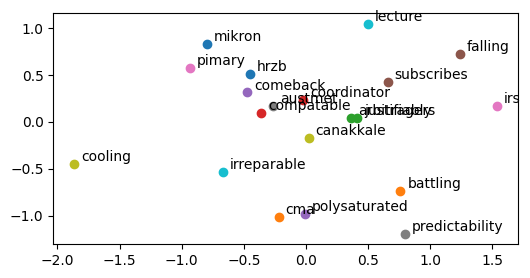

In [32]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocab[:20]):  # loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points")
plt.show()

## 6. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

If $p$ and $q$ is super similar, the result is 1 otherwise 0.


In [33]:
vocab

['mikron',
 'battling',
 'arbitragers',
 'compatable',
 'polysaturated',
 'subscribes',
 'pimary',
 'austmet',
 'cooling',
 'irreparable',
 'hrzb',
 'cma',
 'justifiably',
 'coordinator',
 'comeback',
 'falling',
 'irs',
 'predictability',
 'canakkale',
 'lecture',
 'jesus',
 'copyrights',
 'wrote',
 'shouldn',
 'soaring',
 'hormel',
 'resevoir',
 'ecop',
 'wet',
 'internation',
 'estenssoro',
 'halted',
 'engaged',
 'helps',
 'regatta',
 'dilutions',
 'seamen',
 'basing',
 'gottschalks',
 'replenished',
 'panic',
 'tuberculosis',
 'energetic',
 'lornex',
 'entg',
 'briskly',
 'waferboard',
 'reintegro',
 'novamin',
 'alternative',
 'foreigned',
 'symbolic',
 'celanese',
 'amylum',
 'marco',
 'private',
 'deems',
 'cal',
 'brooke',
 'grievances',
 'harrowing',
 'pension',
 'fritz',
 'seag',
 'allocating',
 'mony',
 'florjancic',
 'catena',
 'offsets',
 'uproar',
 'hangzhou',
 'digits',
 'suggest',
 'barschel',
 'barges',
 'kahn',
 'tentonian',
 'wako',
 'rate',
 'provinces',
 'institut

In [35]:
# let's try similarity between first and second, and second and third
cat = get_embed("cat")
fruit = get_embed("fruit")
animal = get_embed("animal")

In [36]:
# numpy version
from numpy import dot
from numpy.linalg import norm


def cos_sim(a, b):
    cos_sim = dot(a, b) / (norm(a) * norm(b))
    return cos_sim


print(f"cat vs. fruit: ", cos_sim(cat, fruit))
print(f"cat vs. animal: ", cos_sim(cat, animal))
print(f"cat vs. cat: ", cos_sim(cat, cat))

cat vs. fruit:  0.6655236039496065
cat vs. animal:  0.25929646001542195
cat vs. cat:  0.9999999999999998


In [37]:
# scipy version
from scipy import spatial


def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(
        a, b
    )  # distance = 1 - similarlity, because scipy only gives distance
    return cos_sim


print(f"cat vs. fruit: ", cos_sim(cat, fruit))
print(f"cat vs. animal: ", cos_sim(cat, animal))
print(f"cat vs. cat: ", cos_sim(cat, cat))

cat vs. fruit:  0.6655236039496065
cat vs. animal:  0.25929646001542195
cat vs. cat:  1.0
